In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import zipfile
import os
import pathlib
import matplotlib.image as mpimg
import random
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import binary_crossentropy, categorical_crossentropy
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPool2D, Input
from tensorflow.keras.utils import image_dataset_from_directory
from tensorflow.keras import Sequential
import datetime
import tensorflow_hub as hub

In [2]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py 

from helper_functions import create_tensorboard_callback, plot_loss_curves, unzip_data, walk_through_dir

--2023-04-01 00:34:18--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2023-04-01 00:34:18 (57.5 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [3]:
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip

--2023-04-01 00:34:19--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 173.194.202.128, 173.194.203.128, 74.125.20.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|173.194.202.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip’

10_food_classes_10_ 100%[===================>] 160.74M   102MB/s    in 1.6s    

2023-04-01 00:34:21 (102 MB/s) - ‘10_food_classes_10_percent.zip’ saved [168546183/168546183]



In [4]:
unzip_data("/content/10_food_classes_10_percent.zip")

In [5]:
train_dir = "/content/10_food_classes_10_percent/train"
test_dir = "/content/10_food_classes_10_percent/test"

In [6]:
IMAGE_SIZE = (224, 224)
INPUT_SHAPE = (224, 224, 3)

In [7]:
train_data_10percent = image_dataset_from_directory(train_dir,
                                                    image_size = IMAGE_SIZE,
                                                    batch_size = 32,
                                                    label_mode = "categorical")

test_data_10percent = image_dataset_from_directory(test_dir,
                                          image_size = IMAGE_SIZE,
                                          batch_size = 32,
                                          label_mode = "categorical")

Found 750 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [8]:
train_data_10percent

<_BatchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 10), dtype=tf.float32, name=None))>

In [9]:
train_data_10percent.class_names

['chicken_curry',
 'chicken_wings',
 'fried_rice',
 'grilled_salmon',
 'hamburger',
 'ice_cream',
 'pizza',
 'ramen',
 'steak',
 'sushi']

In [10]:
for images, labels in train_data_10percent.take(1):
  print(images, labels)

tf.Tensor(
[[[[2.49489807e+02 1.88102051e+02 1.05357140e+02]
   [2.37173462e+02 1.73979599e+02 8.71734695e+01]
   [2.39505096e+02 1.72637756e+02 8.26530609e+01]
   ...
   [1.36147781e+02 1.00933510e+02 1.04504982e+02]
   [1.45275543e+02 1.14418434e+02 1.19346992e+02]
   [1.41147125e+02 1.13320641e+02 1.18320641e+02]]

  [[2.43056122e+02 1.77173462e+02 9.05816269e+01]
   [2.45020416e+02 1.78168365e+02 8.94438782e+01]
   [2.42061234e+02 1.70775513e+02 7.84336700e+01]
   ...
   [1.56719177e+02 1.19877434e+02 1.20203941e+02]
   [1.29352051e+02 9.76326904e+01 9.87704544e+01]
   [1.43193665e+02 1.13265099e+02 1.15407959e+02]]

  [[2.53653061e+02 1.87081635e+02 9.80969391e+01]
   [2.48984695e+02 1.82015305e+02 9.11428528e+01]
   [2.37739792e+02 1.67336731e+02 7.46173477e+01]
   ...
   [1.25872444e+02 8.37245407e+01 8.16786041e+01]
   [1.61219421e+02 1.22933723e+02 1.21790878e+02]
   [1.34117096e+02 9.76885300e+01 9.74742432e+01]]

  ...

  [[1.48280624e+02 1.33280624e+02 1.28280624e+02]
   [1

In [11]:
base_model = tf.keras.applications.efficientnet.EfficientNetB0(include_top=False)

base_model.trainable = False

16705208/16705208 [==============================] - 0s 0us/step


In [12]:
inputs = Input(shape = INPUT_SHAPE, name="input_layer")
# x = tf.keras.layers.Rescaling(1./255)(inputs)
x = base_model(inputs)
print(f"shape : {x.shape}")
x = tf.keras.layers.GlobalAveragePooling2D()(x)
print(f"shape : {x.shape}")
outputs = Dense(10, activation="softmax", name="output_layer")(x)

model1 = tf.keras.Model(inputs, outputs)

model1.compile(loss = categorical_crossentropy,
               optimizer = Adam(),
               metrics = ["accuracy"])

history1 = model1.fit(train_data_10percent, epochs=5, steps_per_epoch=len(train_data_10percent), validation_data=test_data_10percent, validation_steps=int(0.25*len(test_data_10percent)))

shape : (None, 7, 7, 1280)
shape : (None, 1280)
Epoch 1/5
24/24 [==============================] - 21s 250ms/step - loss: 1.8795 - accuracy: 0.4253 - val_loss: 1.2807 - val_accuracy: 0.7451
Epoch 2/5
24/24 [==============================] - 7s 266ms/step - loss: 1.0996 - accuracy: 0.7627 - val_loss: 0.8469 - val_accuracy: 0.8322
Epoch 3/5
24/24 [==============================] - 9s 355ms/step - loss: 0.7863 - accuracy: 0.8347 - val_loss: 0.6917 - val_accuracy: 0.8438
Epoch 4/5
24/24 [==============================] - 6s 232ms/step - loss: 0.6451 - accuracy: 0.8520 - val_loss: 0.6223 - val_accuracy: 0.8454
Epoch 5/5
24/24 [==============================] - 4s 135ms/step - loss: 0.5438 - accuracy: 0.8787 - val_loss: 0.5601 - val_accuracy: 0.8651


In [13]:
model1.evaluate(test_data_10percent)

79/79 [==============================] - 8s 91ms/step - loss: 0.5598 - accuracy: 0.8568


[0.559773325920105, 0.8568000197410583]

In [14]:
for layer_number, layer in enumerate(base_model.layers):
  print(layer_number, layer.name)

0 input_1
1 rescaling
2 normalization
3 rescaling_1
4 stem_conv_pad
5 stem_conv
6 stem_bn
7 stem_activation
8 block1a_dwconv
9 block1a_bn
10 block1a_activation
11 block1a_se_squeeze
12 block1a_se_reshape
13 block1a_se_reduce
14 block1a_se_expand
15 block1a_se_excite
16 block1a_project_conv
17 block1a_project_bn
18 block2a_expand_conv
19 block2a_expand_bn
20 block2a_expand_activation
21 block2a_dwconv_pad
22 block2a_dwconv
23 block2a_bn
24 block2a_activation
25 block2a_se_squeeze
26 block2a_se_reshape
27 block2a_se_reduce
28 block2a_se_expand
29 block2a_se_excite
30 block2a_project_conv
31 block2a_project_bn
32 block2b_expand_conv
33 block2b_expand_bn
34 block2b_expand_activation
35 block2b_dwconv
36 block2b_bn
37 block2b_activation
38 block2b_se_squeeze
39 block2b_se_reshape
40 block2b_se_reduce
41 block2b_se_expand
42 block2b_se_excite
43 block2b_project_conv
44 block2b_project_bn
45 block2b_drop
46 block2b_add
47 block3a_expand_conv
48 block3a_expand_bn
49 block3a_expand_activation
5

In [15]:
base_model.summary()

Model: "efficientnetb0"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 rescaling (Rescaling)          (None, None, None,   0           ['input_1[0][0]']                
                                3)                                                                
                                                                                                  
 normalization (Normalization)  (None, None, None,   7           ['rescaling[0][0]']              
                                3)                                                   

In [16]:
model1.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 4,062,381
Trainable params: 12,810
Non-trainable params: 4,049,571
_________________________________________________________________


<Axes: >

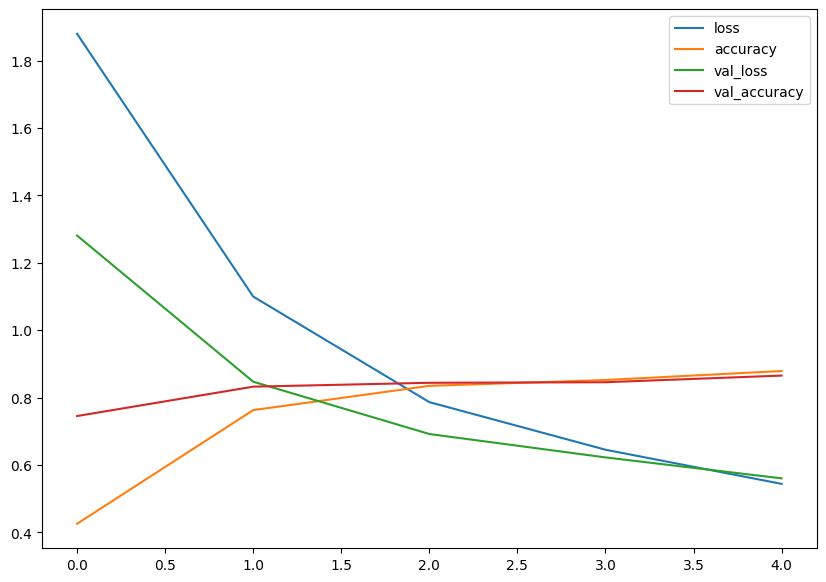

In [17]:
pd.DataFrame(history1.history).plot(figsize=(10, 7))

In [18]:
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_1_percent.zip

--2023-04-01 00:35:42--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_1_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.195.128, 142.250.99.128, 142.250.107.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.195.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 133612354 (127M) [application/zip]
Saving to: ‘10_food_classes_1_percent.zip’

10_food_classes_1_p 100%[===================>] 127.42M   131MB/s    in 1.0s    

2023-04-01 00:35:43 (131 MB/s) - ‘10_food_classes_1_percent.zip’ saved [133612354/133612354]



In [19]:
unzip_data("/content/10_food_classes_1_percent.zip")

In [20]:
train_dir_1_percent = "/content/10_food_classes_1_percent/train"
test_dir_1_percent = "/content/10_food_classes_1_percent/test"

In [21]:
train_data_1_percent = image_dataset_from_directory(train_dir_1_percent,
                                                    image_size = IMAGE_SIZE,
                                                    label_mode = "categorical",
                                                    batch_size = 32)

test_data_1_percent = image_dataset_from_directory(test_dir_1_percent,
                                         image_size = IMAGE_SIZE,
                                         label_mode = "categorical",
                                         batch_size = 32)

Found 70 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [22]:
data_aug_model = Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.2),
    tf.keras.layers.RandomZoom(0.2),
    tf.keras.layers.RandomHeight(0.2),
    tf.keras.layers.RandomWidth(0.2),
    # tf.keras.layers.Rescale(1./255), # not needed for efficientnet
], name = "data_augmentation")

In [23]:
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False
inputs = Input(shape = INPUT_SHAPE)
x = data_aug_model(inputs, training = True)
x = base_model(x, training = False)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
outputs = Dense(10, activation="softmax")(x)

model2 = tf.keras.Model(inputs, outputs)
model2.compile(loss = categorical_crossentropy,
               optimizer = Adam(),
               metrics = ["accuracy"])

history2 = model2.fit(train_data_1_percent, epochs=5, steps_per_epoch=len(train_data_1_percent), validation_data=test_data_1_percent, validation_steps=int(0.25*len(test_data_1_percent)))

Epoch 1/5
3/3 [==============================] - 23s 7s/step - loss: 2.4677 - accuracy: 0.0143 - val_loss: 2.3458 - val_accuracy: 0.1151
Epoch 2/5
3/3 [==============================] - 10s 5s/step - loss: 2.2177 - accuracy: 0.0714 - val_loss: 2.2136 - val_accuracy: 0.1957
Epoch 3/5
3/3 [==============================] - 9s 4s/step - loss: 2.0186 - accuracy: 0.2857 - val_loss: 2.0976 - val_accuracy: 0.2401
Epoch 4/5
3/3 [==============================] - 9s 4s/step - loss: 1.8622 - accuracy: 0.3857 - val_loss: 2.0223 - val_accuracy: 0.2878
Epoch 5/5
3/3 [==============================] - 8s 4s/step - loss: 1.6595 - accuracy: 0.6429 - val_loss: 1.9284 - val_accuracy: 0.3586


In [24]:
model2.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 data_augmentation (Sequenti  (None, None, None, 3)    0         
 al)                                                             
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_average_pooling2d_1   (None, 1280)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense (Dense)               (None, 10)                12810     
                                                                 
Total params: 4,062,381
Trainable params: 12,810
Non-traina

In [25]:
model2.evaluate(test_data_1_percent)

79/79 [==============================] - 27s 333ms/step - loss: 1.9178 - accuracy: 0.3756


[1.9178394079208374, 0.37560001015663147]

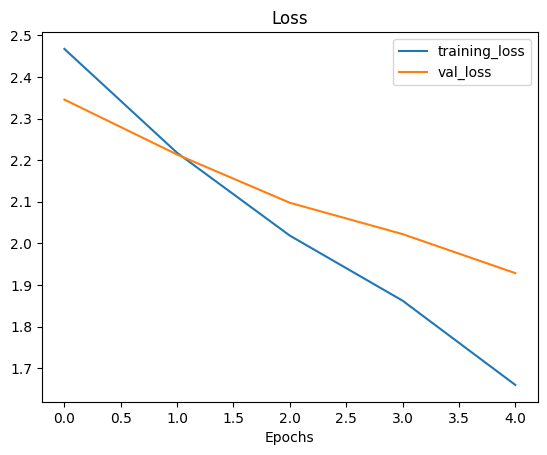

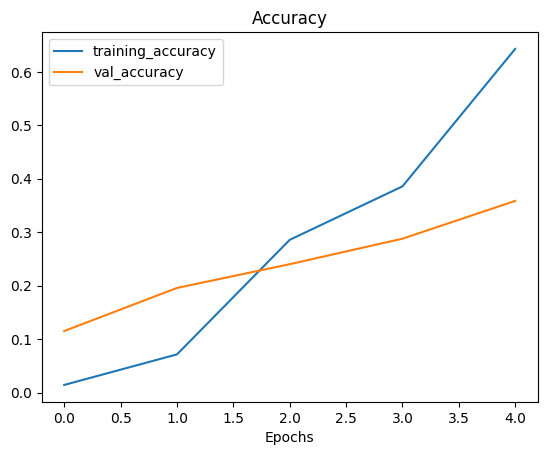

In [26]:
plot_loss_curves(history2)

In [27]:
# model 3
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False

data_aug_model = Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomZoom(0.2),
    tf.keras.layers.RandomHeight(0.2),
    tf.keras.layers.RandomWidth(0.2),
    tf.keras.layers.RandomRotation(0.2),
])

inputs = Input(shape = INPUT_SHAPE)
x = data_aug_model(inputs, training = True),
x = base_model(x, training = False)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
outputs = Dense(10, activation = "softmax")(x)

model3 = tf.keras.Model(inputs, outputs)
model3.compile(loss = categorical_crossentropy,
               optimizer = Adam(),
               metrics = ["accuracy"])

history3 = model3.fit(train_data_10percent, 
                      epochs=5, 
                      steps_per_epoch=len(train_data_10percent), 
                      validation_data=test_data_10percent, 
                      validation_steps=int(0.25*len(test_data_10percent)),
                      callbacks=[tf.keras.callbacks.ModelCheckpoint(
                                                         filepath="model3_checkpoint",
                                                         save_weights_only=True,
                                                         save_best_only=False,
                                                         save_freq="epoch",
                                                         verbose=1)])

Epoch 1/5
24/24 [==============================] - ETA: 0s - loss: 1.9619 - accuracy: 0.3507
Epoch 1: saving model to model3_checkpoint
24/24 [==============================] - 23s 682ms/step - loss: 1.9619 - accuracy: 0.3507 - val_loss: 1.4870 - val_accuracy: 0.6513
Epoch 2/5
24/24 [==============================] - ETA: 0s - loss: 1.3074 - accuracy: 0.7107
Epoch 2: saving model to model3_checkpoint
24/24 [==============================] - 13s 554ms/step - loss: 1.3074 - accuracy: 0.7107 - val_loss: 1.0819 - val_accuracy: 0.7697
Epoch 3/5
24/24 [==============================] - ETA: 0s - loss: 0.9799 - accuracy: 0.7800
Epoch 3: saving model to model3_checkpoint
24/24 [==============================] - 13s 512ms/step - loss: 0.9799 - accuracy: 0.7800 - val_loss: 0.8707 - val_accuracy: 0.8026
Epoch 4/5
24/24 [==============================] - ETA: 0s - loss: 0.8263 - accuracy: 0.8080
Epoch 4: saving model to model3_checkpoint
24/24 [==============================] - 17s 725ms/step - lo

In [28]:
model3.evaluate(test_data_10percent)

79/79 [==============================] - 20s 240ms/step - loss: 0.7539 - accuracy: 0.8008


[0.7539339065551758, 0.8008000254631042]

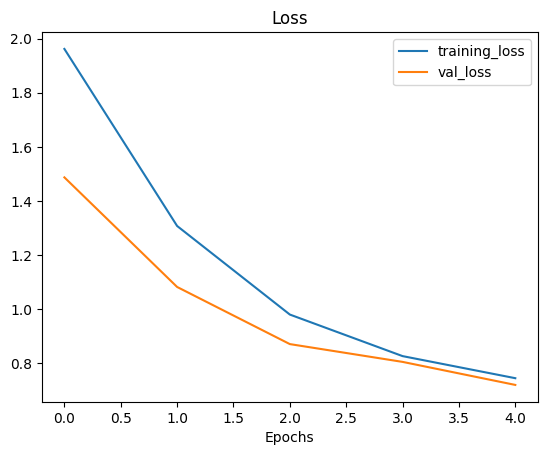

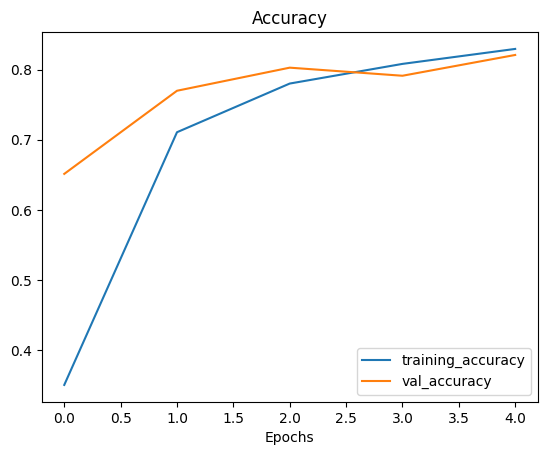

In [29]:
plot_loss_curves(history3)

In [30]:
# model 4
base_model.trainable = False

inputs = Input(shape = INPUT_SHAPE)
x = data_aug_model(inputs, training = True),
x = base_model(x, training = False)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
outputs = Dense(10, activation = "softmax")(x)

model4 = tf.keras.Model(inputs, outputs)


model4.compile(loss = categorical_crossentropy,
               optimizer = Adam(),
               metrics = ["accuracy"])
model4.load_weights("model3_checkpoint")


In [31]:
base_model.trainable = True
for layer in base_model.layers[:-10]:
  layer.trainable = False

# for i, layer in enumerate(base_model.layers):
#   print(i, layer, layer.trainable)

model4.compile(loss = categorical_crossentropy,
               optimizer = Adam(learning_rate = 0.0001),
               metrics = ["accuracy"])

fine_tune_epochs = 10 # initial(5) + 5

history4 = model4.fit(train_data_10percent, 
                      epochs=fine_tune_epochs, 
                      steps_per_epoch=len(train_data_10percent), 
                      validation_data=test_data_10percent, 
                      validation_steps=int(0.25*len(test_data_10percent)),
                      callbacks=[tf.keras.callbacks.ModelCheckpoint(
                                                         filepath="model4_checkpoint",
                                                         save_weights_only=True,
                                                         save_best_only=False,
                                                         save_freq="epoch",
                                                         verbose=1)],
                      initial_epoch = history3.epoch[-1])

Epoch 5/10
24/24 [==============================] - ETA: 0s - loss: 0.6325 - accuracy: 0.8200
Epoch 5: saving model to model4_checkpoint
24/24 [==============================] - 25s 581ms/step - loss: 0.6325 - accuracy: 0.8200 - val_loss: 0.6002 - val_accuracy: 0.8092
Epoch 6/10
24/24 [==============================] - ETA: 0s - loss: 0.4918 - accuracy: 0.8693
Epoch 6: saving model to model4_checkpoint
24/24 [==============================] - 18s 731ms/step - loss: 0.4918 - accuracy: 0.8693 - val_loss: 0.5584 - val_accuracy: 0.8207
Epoch 7/10
24/24 [==============================] - ETA: 0s - loss: 0.4287 - accuracy: 0.8853
Epoch 7: saving model to model4_checkpoint
24/24 [==============================] - 14s 526ms/step - loss: 0.4287 - accuracy: 0.8853 - val_loss: 0.5838 - val_accuracy: 0.8141
Epoch 8/10
24/24 [==============================] - ETA: 0s - loss: 0.3829 - accuracy: 0.8973
Epoch 8: saving model to model4_checkpoint
24/24 [==============================] - 12s 490ms/step 

In [32]:
model4.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 sequential (Sequential)     (None, None, None, 3)     0         
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_average_pooling2d_3   (None, 1280)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_2 (Dense)             (None, 10)                12810     
                                                                 
Total params: 4,062,381
Trainable params: 906,042
Non-trainable params: 3,156,339
___________________________________________

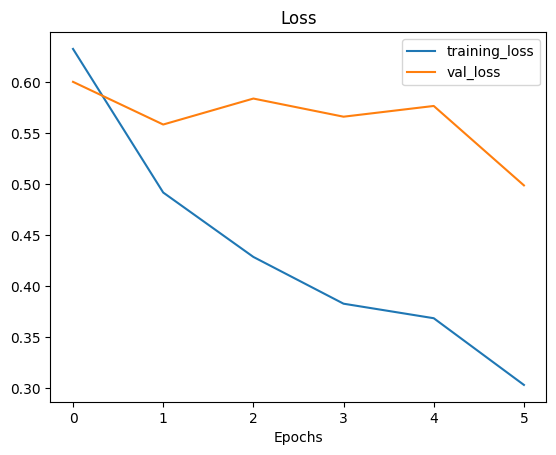

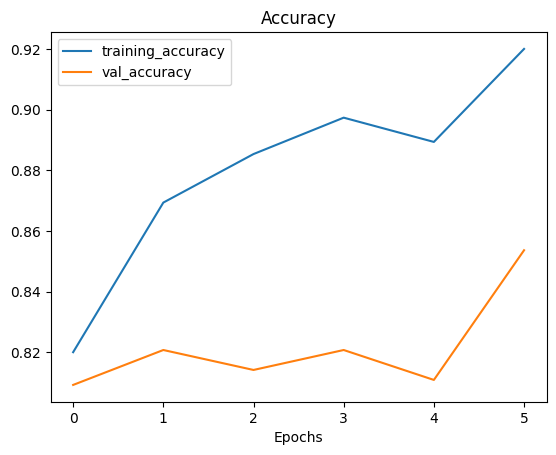

In [33]:
plot_loss_curves(history4)

In [34]:
model4.evaluate(test_data_10percent)

79/79 [==============================] - 17s 205ms/step - loss: 0.5503 - accuracy: 0.8164


[0.5503450632095337, 0.8163999915122986]

In [35]:
! wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_all_data.zip

--2023-04-01 00:41:39--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_all_data.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.195.128, 172.253.117.128, 142.250.99.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.195.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 519183241 (495M) [application/zip]
Saving to: ‘10_food_classes_all_data.zip’

10_food_classes_all 100%[===================>] 495.13M   151MB/s    in 3.4s    

2023-04-01 00:41:42 (148 MB/s) - ‘10_food_classes_all_data.zip’ saved [519183241/519183241]



In [36]:
unzip_data("/content/10_food_classes_all_data.zip")

In [37]:
train_full_dir = "/content/10_food_classes_all_data/train"
test_dir = "/content/10_food_classes_all_data/test"

In [38]:
train_data_full = image_dataset_from_directory(train_full_dir, 
                                               image_size = IMAGE_SIZE,
                                               label_mode = "categorical",
                                               batch_size = 32)

test_data = image_dataset_from_directory(test_dir, 
                                               image_size = IMAGE_SIZE,
                                               label_mode = "categorical",
                                               batch_size = 32)

Found 7500 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [39]:
model5 = model3
model5.load_weights("model3_checkpoint")

In [40]:
model5.evaluate(test_data)

79/79 [==============================] - 16s 199ms/step - loss: 0.7628 - accuracy: 0.7992


[0.7627929449081421, 0.7991999983787537]

In [41]:
model5.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 sequential (Sequential)     (None, None, None, 3)     0         
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_average_pooling2d_2   (None, 1280)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_1 (Dense)             (None, 10)                12810     
                                                                 
Total params: 4,062,381
Trainable params: 906,042
Non-trainable params: 3,156,339
___________________________________________

In [42]:
for i, layer in enumerate(model5.layers):
  print(i, layer.name, layer.trainable)

0 input_5 True
1 sequential True
2 efficientnetb0 True
3 global_average_pooling2d_2 True
4 dense_1 True


In [43]:
model5.layers[2].trainable=True

In [44]:
for i, layer in enumerate(model5.layers[2].layers):
  print(i, layer.name, layer.trainable)

0 input_4 True
1 rescaling_4 True
2 normalization_2 True
3 rescaling_5 True
4 stem_conv_pad True
5 stem_conv True
6 stem_bn True
7 stem_activation True
8 block1a_dwconv True
9 block1a_bn True
10 block1a_activation True
11 block1a_se_squeeze True
12 block1a_se_reshape True
13 block1a_se_reduce True
14 block1a_se_expand True
15 block1a_se_excite True
16 block1a_project_conv True
17 block1a_project_bn True
18 block2a_expand_conv True
19 block2a_expand_bn True
20 block2a_expand_activation True
21 block2a_dwconv_pad True
22 block2a_dwconv True
23 block2a_bn True
24 block2a_activation True
25 block2a_se_squeeze True
26 block2a_se_reshape True
27 block2a_se_reduce True
28 block2a_se_expand True
29 block2a_se_excite True
30 block2a_project_conv True
31 block2a_project_bn True
32 block2b_expand_conv True
33 block2b_expand_bn True
34 block2b_expand_activation True
35 block2b_dwconv True
36 block2b_bn True
37 block2b_activation True
38 block2b_se_squeeze True
39 block2b_se_reshape True
40 block2b

In [45]:
for i, layer in enumerate(model5.layers[2].layers[:-10]):
  layer.trainable = False

In [46]:
for i, layer in enumerate(model5.layers[2].layers):
  print(i, layer.name, layer.trainable)

0 input_4 False
1 rescaling_4 False
2 normalization_2 False
3 rescaling_5 False
4 stem_conv_pad False
5 stem_conv False
6 stem_bn False
7 stem_activation False
8 block1a_dwconv False
9 block1a_bn False
10 block1a_activation False
11 block1a_se_squeeze False
12 block1a_se_reshape False
13 block1a_se_reduce False
14 block1a_se_expand False
15 block1a_se_excite False
16 block1a_project_conv False
17 block1a_project_bn False
18 block2a_expand_conv False
19 block2a_expand_bn False
20 block2a_expand_activation False
21 block2a_dwconv_pad False
22 block2a_dwconv False
23 block2a_bn False
24 block2a_activation False
25 block2a_se_squeeze False
26 block2a_se_reshape False
27 block2a_se_reduce False
28 block2a_se_expand False
29 block2a_se_excite False
30 block2a_project_conv False
31 block2a_project_bn False
32 block2b_expand_conv False
33 block2b_expand_bn False
34 block2b_expand_activation False
35 block2b_dwconv False
36 block2b_bn False
37 block2b_activation False
38 block2b_se_squeeze Fals

In [47]:
for i, layer in enumerate(model5.layers):
  print(i, layer.name, layer.trainable)

0 input_5 True
1 sequential True
2 efficientnetb0 True
3 global_average_pooling2d_2 True
4 dense_1 True


In [48]:
model5.compile(loss = categorical_crossentropy,
               optimizer = Adam(learning_rate = 0.0001),
               metrics=["accuracy"])

In [50]:
history5 = model5.fit(train_data_full,
                      epochs = 10, 
                      steps_per_epoch = len(train_data_full),
                      validation_data = test_data,
                      validation_steps = int(0.25*len(test_data)),
                      callbacks=[tf.keras.callbacks.ModelCheckpoint(
                                                         filepath="model5_checkpoint",
                                                         save_weights_only=True,
                                                         save_best_only=False,
                                                         save_freq="epoch",
                                                         verbose=1)],
                      initial_epoch=history3.epoch[-1])

Epoch 5/10
235/235 [==============================] - ETA: 0s - loss: 0.3923 - accuracy: 0.8744
Epoch 5: saving model to model5_checkpoint
235/235 [==============================] - 40s 168ms/step - loss: 0.3923 - accuracy: 0.8744 - val_loss: 0.3554 - val_accuracy: 0.8832
Epoch 6/10
235/235 [==============================] - ETA: 0s - loss: 0.3630 - accuracy: 0.8848
Epoch 6: saving model to model5_checkpoint
235/235 [==============================] - 39s 164ms/step - loss: 0.3630 - accuracy: 0.8848 - val_loss: 0.3356 - val_accuracy: 0.8980
Epoch 7/10
235/235 [==============================] - ETA: 0s - loss: 0.3350 - accuracy: 0.8904
Epoch 7: saving model to model5_checkpoint
235/235 [==============================] - 36s 153ms/step - loss: 0.3350 - accuracy: 0.8904 - val_loss: 0.3542 - val_accuracy: 0.8898
Epoch 8/10
235/235 [==============================] - ETA: 0s - loss: 0.3160 - accuracy: 0.8981
Epoch 8: saving model to model5_checkpoint
235/235 [==============================] -

In [51]:
model5.evaluate(test_data)

79/79 [==============================] - 10s 119ms/step - loss: 0.3370 - accuracy: 0.8924


[0.3369666635990143, 0.8924000263214111]

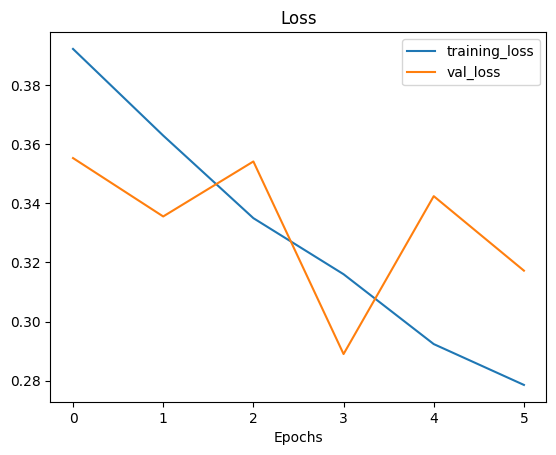

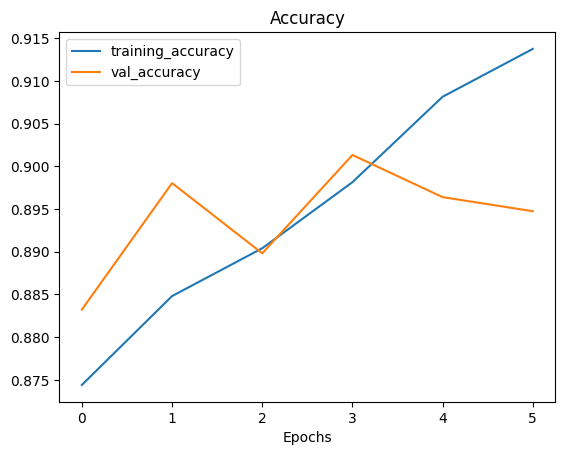

In [52]:
plot_loss_curves(history5)